### 1. Data Exploration and Understanding

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Load the data
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

print("Training data shape:", train_data.shape)
print("Test data shape:", test_data.shape)
print("\nFirst few rows of target variable:")
print(train_data['SalePrice'].describe())


Training data shape: (1460, 81)
Test data shape: (1459, 80)

First few rows of target variable:
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


### 2. Exploratory Data Analysis
The dataset shows a right-skewed distribution of house prices, with most houses priced between $100,000-$300,000. Key relationships observed include strong correlations between Overall Quality, living area, and garage features with sale prices.

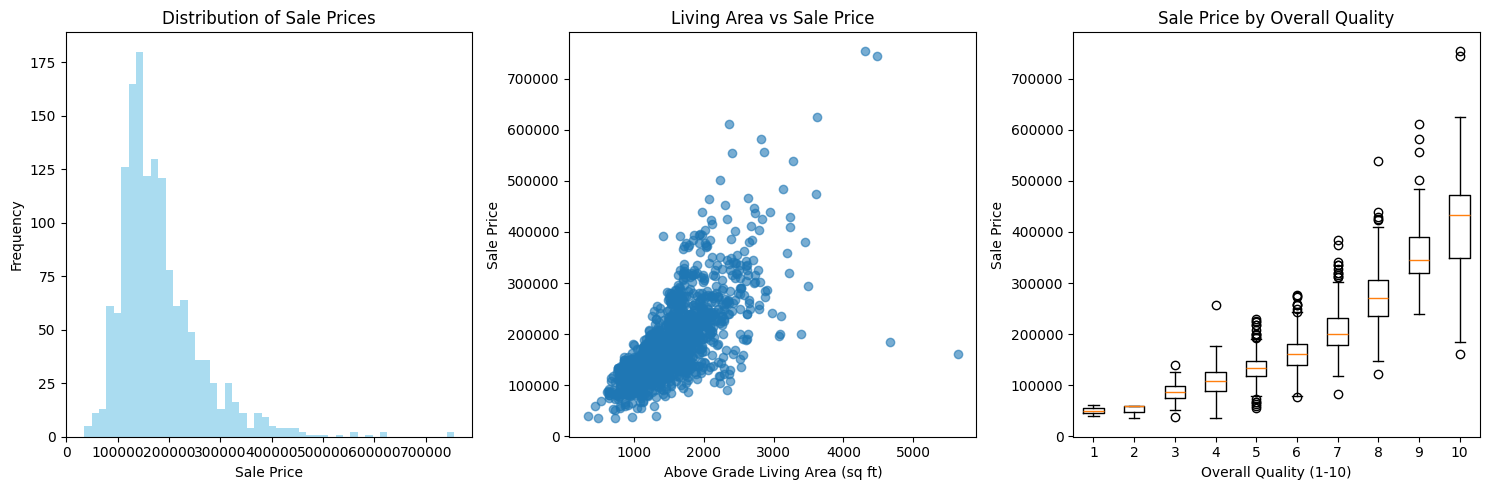

In [10]:
# Visualize target variable distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(train_data['SalePrice'], bins=50, alpha=0.7, color='skyblue')
plt.title('Distribution of Sale Prices')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.scatter(train_data['GrLivArea'], train_data['SalePrice'], alpha=0.6)
plt.title('Living Area vs Sale Price')
plt.xlabel('Above Grade Living Area (sq ft)')
plt.ylabel('Sale Price')

plt.subplot(1, 3, 3)
plt.boxplot([train_data[train_data['OverallQual']==i]['SalePrice'] for i in range(1,11)])
plt.title('Sale Price by Overall Quality')
plt.xlabel('Overall Quality (1-10)')
plt.ylabel('Sale Price')

plt.tight_layout()
plt.show()


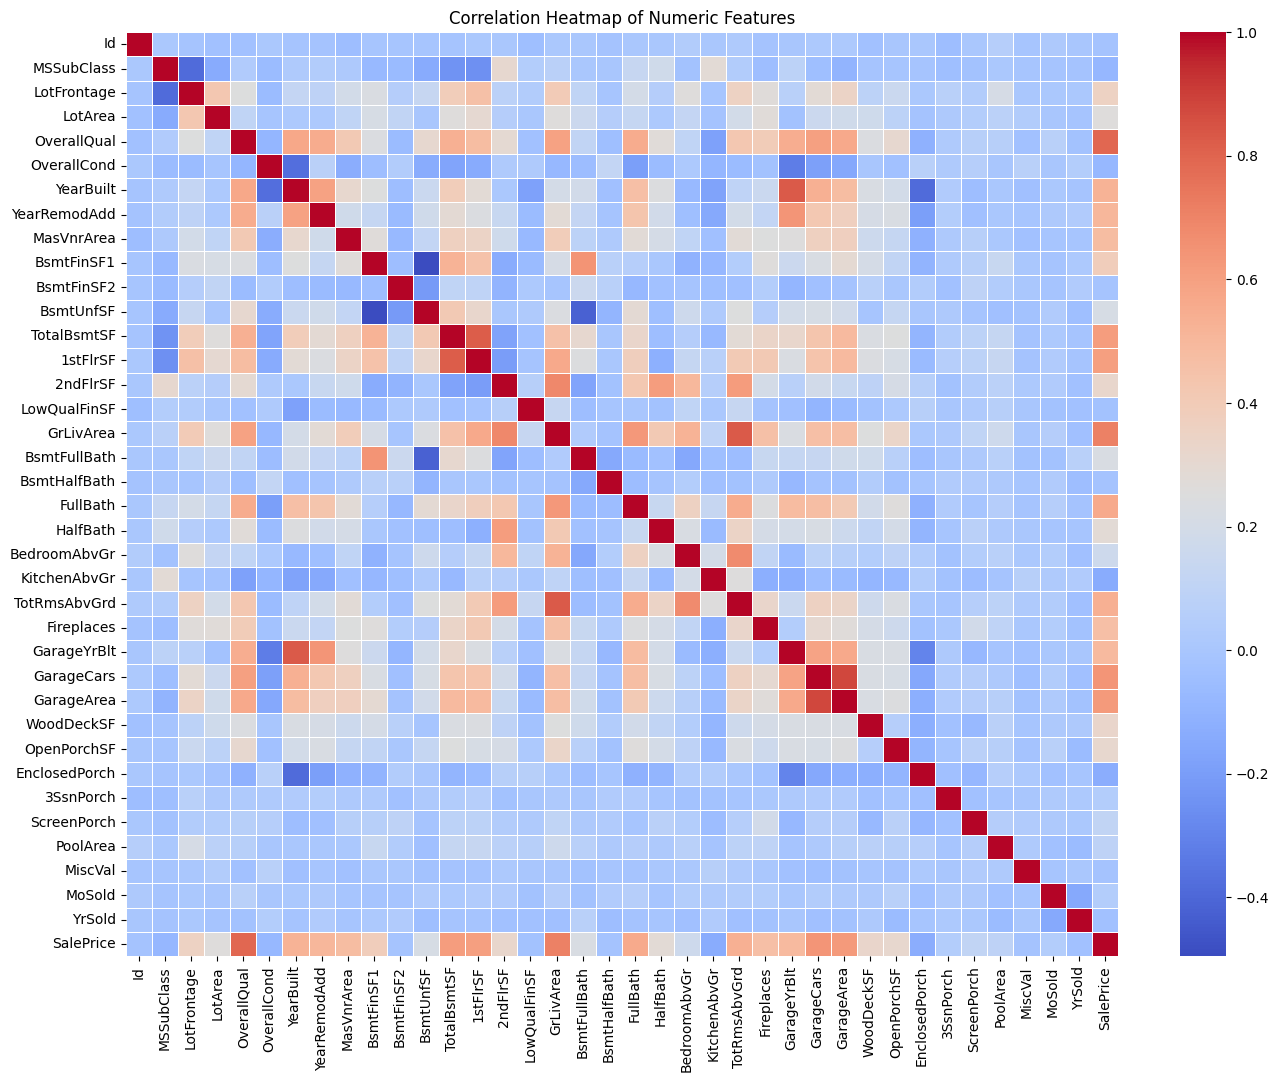

In [11]:
# Correlation Heatmap of Numeric Features
plt.figure(figsize=(16, 12))
numeric_feats = train_data.select_dtypes(include=[np.number])
correlation_matrix = numeric_feats.corr()

# Full heatmap
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

### 3. Data Preprocessing and Cleaning

In [12]:
def preprocess_data(df, is_training=True):
    """Comprehensive data preprocessing function"""
    
    # Create a copy to avoid modifying original data
    data = df.copy()
    
    # Handle missing values strategically
    # Numerical features - fill with median/mode based on context
    numerical_features = data.select_dtypes(include=[np.number]).columns
    
    # LotFrontage: fill with neighborhood median
    if 'LotFrontage' in data.columns:
        data['LotFrontage'] = data.groupby('Neighborhood')['LotFrontage'].transform(
            lambda x: x.fillna(x.median()))
    
    # Garage features: fill with 0 for missing garages
    garage_cols = ['GarageYrBlt', 'GarageArea', 'GarageCars']
    for col in garage_cols:
        if col in data.columns:
            data[col].fillna(0, inplace=True)
    
    # Basement features: fill with 0 for no basement
    basement_cols = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 
                     'BsmtFullBath', 'BsmtHalfBath']
    for col in basement_cols:
        if col in data.columns:
            data[col].fillna(0, inplace=True)
    
    # Masonry veneer area: fill with 0
    if 'MasVnrArea' in data.columns:
        data['MasVnrArea'].fillna(0, inplace=True)
    
    # Categorical features - fill with 'None' or most frequent
    categorical_features = data.select_dtypes(include=['object']).columns
    
    # Features where 'None' makes sense
    none_features = ['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
                     'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType',
                     'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
                     'MiscFeature']
    
    for feature in none_features:
        if feature in data.columns:
            data[feature].fillna('None', inplace=True)
    
    # Fill remaining categorical features with mode
    for feature in categorical_features:
        if feature in data.columns:
            mode_value = data[feature].mode()[0] if len(data[feature].mode()) > 0 else 'Unknown'
            data[feature].fillna(mode_value, inplace=True)
    
    return data

# Preprocess the data
train_processed = preprocess_data(train_data, is_training=True)
test_processed = preprocess_data(test_data, is_training=False)

print("Missing values after preprocessing:")
print("Training data:", train_processed.isnull().sum().sum())
print("Test data:", test_processed.isnull().sum().sum())


Missing values after preprocessing:
Training data: 0
Test data: 0


### 4. Creative Feature Engineering

In [13]:
def engineer_features(df):
    """Create meaningful engineered features"""
    
    data = df.copy()
    
    # Age-related features
    data['HouseAge'] = data['YrSold'] - data['YearBuilt']
    data['YearsSinceRemodel'] = data['YrSold'] - data['YearRemodAdd']
    data['IsNew'] = (data['HouseAge'] <= 2).astype(int)
    
    # Total area features
    data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']
    data['TotalBathrooms'] = data['FullBath'] + (0.5 * data['HalfBath']) + \
                             data['BsmtFullBath'] + (0.5 * data['BsmtHalfBath'])
    
    # Porch area combinations
    porch_cols = ['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']
    data['TotalPorchSF'] = data[porch_cols].sum(axis=1)
    
    # Quality scores
    quality_map = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0}
    
    # Overall quality score
    qual_cols = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 
                 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond']
    
    for col in qual_cols:
        if col in data.columns:
            data[f'{col}_Score'] = data[col].map(quality_map)
    
    # Create quality index
    quality_cols = [col for col in data.columns if col.endswith('_Score')]
    data['QualityIndex'] = data[quality_cols].mean(axis=1)
    
    # Living area per room
    data['LivAreaPerRoom'] = data['GrLivArea'] / (data['TotRmsAbvGrd'] + 1)
    
    # Garage age
    data['GarageAge'] = data['YrSold'] - data['GarageYrBlt']
    data['GarageAge'] = data['GarageAge'].fillna(0)
    
    # Lot area to living area ratio
    data['LotAreaToLivArea'] = data['LotArea'] / data['GrLivArea']
    
    # Basement ratio
    data['BasementRatio'] = data['TotalBsmtSF'] / data['TotalSF']
    
    # Neighborhood price groups (for training data)
    if 'SalePrice' in data.columns:
        neighborhood_price = data.groupby('Neighborhood')['SalePrice'].median().sort_values()
        price_map = {}
        for i, neighborhood in enumerate(neighborhood_price.index):
            if i < len(neighborhood_price) // 3:
                price_map[neighborhood] = 'Low'
            elif i < 2 * len(neighborhood_price) // 3:
                price_map[neighborhood] = 'Medium'
            else:
                price_map[neighborhood] = 'High'
        data['NeighborhoodPriceGroup'] = data['Neighborhood'].map(price_map)
    
    return data

# Apply feature engineering
train_engineered = engineer_features(train_processed)
test_engineered = engineer_features(test_processed)

print("New features created:")
new_features = set(train_engineered.columns) - set(train_processed.columns)
print(list(new_features))


New features created:
['TotalSF', 'GarageQual_Score', 'LivAreaPerRoom', 'LotAreaToLivArea', 'NeighborhoodPriceGroup', 'ExterCond_Score', 'IsNew', 'TotalBathrooms', 'GarageCond_Score', 'FireplaceQu_Score', 'YearsSinceRemodel', 'BsmtCond_Score', 'HouseAge', 'QualityIndex', 'ExterQual_Score', 'HeatingQC_Score', 'GarageAge', 'BasementRatio', 'TotalPorchSF', 'KitchenQual_Score', 'BsmtQual_Score']


### 5. Encoding Categorical Variables

In [14]:
def encode_categorical_features(train_df, test_df, target_col='SalePrice'):
    """Encode categorical features using various methods"""
    
    train_encoded = train_df.copy()
    test_encoded = test_df.copy()
    
    # Separate numerical and categorical columns
    categorical_cols = train_encoded.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = train_encoded.select_dtypes(include=[np.number]).columns.tolist()
    
    if target_col in numerical_cols:
        numerical_cols.remove(target_col)
    
    # Handle categorical variables with target encoding for high cardinality
    high_cardinality = []
    low_cardinality = []
    
    for col in categorical_cols:
        if train_encoded[col].nunique() > 10:
            high_cardinality.append(col)
        else:
            low_cardinality.append(col)
    
    # Target encoding for high cardinality features (only for training)
    if target_col in train_encoded.columns:
        for col in high_cardinality:
            target_mean = train_encoded.groupby(col)[target_col].mean()
            train_encoded[f'{col}_TargetEnc'] = train_encoded[col].map(target_mean)
            test_encoded[f'{col}_TargetEnc'] = test_encoded[col].map(target_mean)
            test_encoded[f'{col}_TargetEnc'].fillna(target_mean.mean(), inplace=True)
    
    # One-hot encoding for low cardinality features
    # train_encoded = pd.get_dummies(train_encoded, columns=low_cardinality, prefix=low_cardinality)
    # test_encoded = pd.get_dummies(test_encoded, columns=low_cardinality, prefix=low_cardinality)
    
    # Filter only those low_cardinality columns that exist in test_encoded
    low_cardinality_in_test = [col for col in low_cardinality if col in test_encoded.columns]

    train_encoded = pd.get_dummies(train_encoded, columns=low_cardinality, prefix=low_cardinality)
    test_encoded = pd.get_dummies(test_encoded, columns=low_cardinality_in_test, prefix=low_cardinality_in_test)

    
    # Align columns between train and test
    train_cols = set(train_encoded.columns)
    test_cols = set(test_encoded.columns)
    
    # Add missing columns to test set
    for col in train_cols - test_cols:
        if col != target_col:
            test_encoded[col] = 0
    
    # Remove extra columns from test set
    for col in test_cols - train_cols:
        test_encoded.drop(col, axis=1, inplace=True)
    
    # Remove original categorical columns
    for col in categorical_cols:
        if col in train_encoded.columns:
            train_encoded.drop(col, axis=1, inplace=True)
        if col in test_encoded.columns:
            test_encoded.drop(col, axis=1, inplace=True)
    
    return train_encoded, test_encoded

# Encode categorical features
train_final, test_final = encode_categorical_features(train_engineered, test_engineered)

print("Final dataset shapes:")
print("Training:", train_final.shape)
print("Test:", test_final.shape)


Final dataset shapes:
Training: (1460, 274)
Test: (1459, 273)


### 6. Model Implementation and Evaluation

In [15]:
# Prepare features and target
X = train_final.drop(['SalePrice', 'Id'], axis=1)
y = np.log1p(train_final['SalePrice'])  # Log transformation for better distribution
X_test = test_final.drop(['Id'], axis=1)

# Ensure test set has same columns as training set
missing_cols = set(X.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0

extra_cols = set(X_test.columns) - set(X.columns)
for col in extra_cols:
    X_test.drop(col, axis=1, inplace=True)

X_test = X_test[X.columns]

# Split training data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features for algorithms that require it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.001),
    'ElasticNet': ElasticNet(alpha=0.001, l1_ratio=0.5),
    'Decision Tree': DecisionTreeRegressor(random_state=42, max_depth=10),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'KNN': KNeighborsRegressor(n_neighbors=5),
    'SVR': SVR(kernel='rbf', C=1000, gamma=0.001)
}

# Evaluate models
results = {}

for name, model in models.items():
    print(f"Training {name}...")
    
    # Use scaled data for models that benefit from it
    if name in ['Ridge Regression', 'Lasso Regression', 'ElasticNet', 'KNN', 'SVR']:
        X_train_model = X_train_scaled
        X_val_model = X_val_scaled
    else:
        X_train_model = X_train
        X_val_model = X_val
    
    # Train model
    model.fit(X_train_model, y_train)
    
    # Make predictions
    y_pred = model.predict(X_val_model)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    
    results[name] = {
        'RMSE': rmse,
        'R2': r2,
        'MAE': mae
    }
    
    print(f"{name} - RMSE: {rmse:.4f}, R2: {r2:.4f}, MAE: {mae:.4f}")

# Display results
results_df = pd.DataFrame(results).T
print("\nModel Comparison:")
print(results_df.round(4))


Training Linear Regression...
Linear Regression - RMSE: 0.1327, R2: 0.9056, MAE: 0.0897
Training Ridge Regression...
Ridge Regression - RMSE: 0.1211, R2: 0.9214, MAE: 0.0872
Training Lasso Regression...
Lasso Regression - RMSE: 0.1206, R2: 0.9221, MAE: 0.0852
Training ElasticNet...
ElasticNet - RMSE: 0.1204, R2: 0.9223, MAE: 0.0857
Training Decision Tree...
Decision Tree - RMSE: 0.1826, R2: 0.8212, MAE: 0.1323
Training Random Forest...
Random Forest - RMSE: 0.1428, R2: 0.8907, MAE: 0.0917
Training Gradient Boosting...
Gradient Boosting - RMSE: 0.1265, R2: 0.9142, MAE: 0.0846
Training KNN...
KNN - RMSE: 0.1965, R2: 0.7931, MAE: 0.1325
Training SVR...
SVR - RMSE: 0.1572, R2: 0.8675, MAE: 0.1064

Model Comparison:
                     RMSE      R2     MAE
Linear Regression  0.1327  0.9056  0.0897
Ridge Regression   0.1211  0.9214  0.0872
Lasso Regression   0.1206  0.9221  0.0852
ElasticNet         0.1204  0.9223  0.0857
Decision Tree      0.1826  0.8212  0.1323
Random Forest      0.1428  

### 7. Advanced Model Tuning

In [16]:
# Hyperparameter tuning for best performing models
def tune_random_forest(X_train, y_train, X_val, y_val):
    """Tune Random Forest hyperparameters"""
    
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 15, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    rf = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_rf = grid_search.best_estimator_
    y_pred = best_rf.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    
    print(f"Best Random Forest RMSE: {rmse:.4f}")
    print(f"Best parameters: {grid_search.best_params_}")
    
    return best_rf

def tune_gradient_boosting(X_train, y_train, X_val, y_val):
    """Tune Gradient Boosting hyperparameters"""
    
    param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1, 0.15],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 0.9, 1.0]
    }
    
    gb = GradientBoostingRegressor(random_state=42)
    grid_search = GridSearchCV(gb, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_gb = grid_search.best_estimator_
    y_pred = best_gb.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    
    print(f"Best Gradient Boosting RMSE: {rmse:.4f}")
    print(f"Best parameters: {grid_search.best_params_}")
    
    return best_gb

# Tune best models
print("Tuning Random Forest...")
best_rf = tune_random_forest(X_train, y_train, X_val, y_val)

print("\nTuning Gradient Boosting...")
best_gb = tune_gradient_boosting(X_train, y_train, X_val, y_val)


Tuning Random Forest...
Best Random Forest RMSE: 0.1429
Best parameters: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}

Tuning Gradient Boosting...
Best Gradient Boosting RMSE: 0.1313
Best parameters: {'learning_rate': 0.15, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


### 8. Ensemble Model and Final Predictions

In [17]:
# Create ensemble model
class EnsembleModel:
    def __init__(self, models, weights=None):
        self.models = models
        self.weights = weights if weights else [1/len(models)] * len(models)
    
    def fit(self, X, y):
        for model in self.models:
            model.fit(X, y)
    
    def predict(self, X):
        predictions = np.array([model.predict(X) for model in self.models])
        return np.average(predictions, axis=0, weights=self.weights)

# Create ensemble with best models
ensemble_models = [best_rf, best_gb, Ridge(alpha=1.0)]
ensemble = EnsembleModel(ensemble_models, weights=[0.4, 0.4, 0.2])

# Train ensemble
ensemble.fit(X_train, y_train)

# Evaluate ensemble
y_pred_ensemble = ensemble.predict(X_val)
ensemble_rmse = np.sqrt(mean_squared_error(y_val, y_pred_ensemble))
ensemble_r2 = r2_score(y_val, y_pred_ensemble)

print(f"\nEnsemble Model Performance:")
print(f"RMSE: {ensemble_rmse:.4f}")
print(f"R2: {ensemble_r2:.4f}")

# Make final predictions
final_predictions = ensemble.predict(X_test)

# Transform back from log scale
final_predictions = np.expm1(final_predictions)

# Create submission file
submission = pd.DataFrame({
    'Id': test_final['Id'],
    'SalePrice': final_predictions
})

submission.to_csv('house_price_predictions.csv', index=False)
print("\nPredictions saved to 'house_price_predictions.csv'")



Ensemble Model Performance:
RMSE: 0.1266
R2: 0.9141

Predictions saved to 'house_price_predictions.csv'


### 9. Feature Importance Analysis

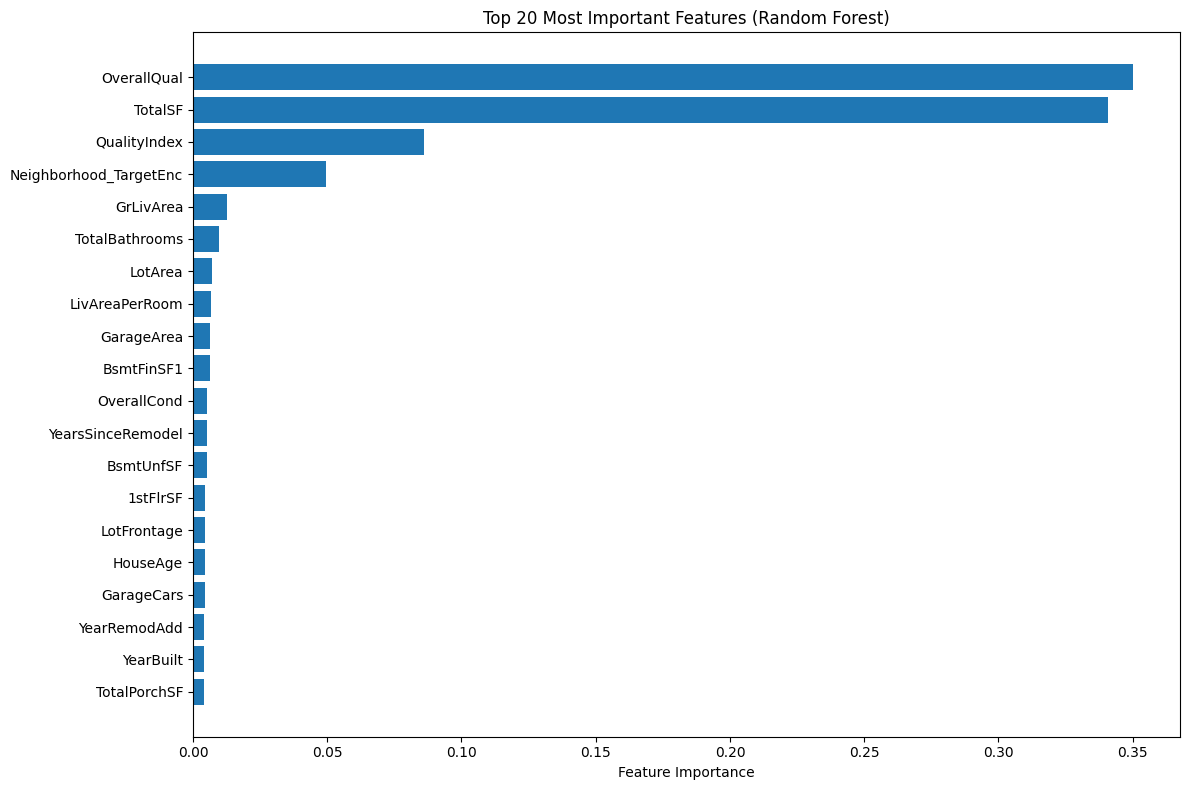

Top 10 Most Important Features:
                   feature  importance
3              OverallQual    0.350110
39                 TotalSF    0.340803
51            QualityIndex    0.086195
56  Neighborhood_TargetEnc    0.049627
15               GrLivArea    0.012541
40          TotalBathrooms    0.009774
2                  LotArea    0.006940
52          LivAreaPerRoom    0.006795
26              GarageArea    0.006270
8               BsmtFinSF1    0.006242


In [18]:
# Analyze feature importance from Random Forest
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 20 most important features
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 20 Most Important Features (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("Top 10 Most Important Features:")
print(feature_importance.head(10))
